# imports, data

In [1]:
from datetime import timedelta
import os, sys
import random
import time

cwd = os.getcwd()

parentdir = os.path.dirname(cwd)
golemdir = parentdir + '/GOLEM'
bamtdir = parentdir + '/BAMT'
sys.path.insert(0, golemdir)
sys.path.insert(0, bamtdir)

import numpy as np
import pandas as pd
from typing import Type

from math import ceil
from pgmpy.estimators import K2Score
from pgmpy.models import BayesianNetwork
from golem.core.adapter import DirectAdapter
from golem.core.dag.convert import graph_structure_as_nx_graph
from golem.core.dag.graph_utils import ordered_subnodes_hierarchy
from golem.core.dag.verification_rules import has_no_cycle, has_no_self_cycled_nodes
from golem.core.log import default_log
from golem.core.optimisers.genetic.gp_optimizer import EvoGraphOptimizer
from golem.core.optimisers.genetic.gp_params import GPAlgorithmParameters
from golem.core.optimisers.genetic.operators.crossover import CrossoverTypesEnum
from golem.core.optimisers.genetic.operators.inheritance import GeneticSchemeTypesEnum
from golem.core.optimisers.genetic.operators.regularization import RegularizationTypesEnum
from golem.core.optimisers.genetic.operators.selection import SelectionTypesEnum
from golem.core.optimisers.graph import OptGraph, OptNode
from golem.core.optimisers.objective import Objective, ObjectiveEvaluate
from golem.core.optimisers.optimization_parameters import GraphRequirements
from golem.core.optimisers.optimizer import GraphGenerationParams, GraphOptimizer
from golem.core.optimisers.random.random_mutation_optimizer import RandomMutationSearchOptimizer
from golem.core.optimisers.random.random_search import RandomSearchOptimizer
from golem.core.optimisers.initial_graphs_generator import InitialPopulationGenerator
from golem.core.paths import project_root


from divided_bn import DividedBN
import bamt.preprocessors as pp
from bamt.networks.continuous_bn import ContinuousBN
from bamt.networks.discrete_bn import DiscreteBN
from bamt.networks.hybrid_bn import HybridBN
from sklearn import preprocessing
from copy import deepcopy

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import multiprocessing as mp
mp.set_start_method('fork')

/home/jerzy/.conda/envs/lsevo/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pigs = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/pigs.csv')
win95pts = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/win95pts.csv')
hailfinder = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/hailfinder.csv')
hepar2 = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/hepar2.csv')
arth150 = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/arth150.csv')
ecoli70 = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/ecoli70.csv', index_col=0)
magic_irri = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/magic-irri.csv', index_col=0)
magic_niab = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/magic-niab.csv', index_col=0)
diabetes = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/sparsebndata/main/data/diabetes.csv')
andes = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/sparsebndata/main/data/andes.csv')

pigs_true = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/pigs_true.csv')
win95pts_true = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/win95pts_true.csv')
hailfinder_true = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/hailfinder_true.csv')
hepar2_true = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/hepar2_true.csv')
arth150_true = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/arth150_true.csv')
ecoli70_true = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/ecoli70_true.csv')
magic_irri_true = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/magic-irri_true.csv')
magic_niab_true = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/magic-niab_true.csv')
andes_true = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/andes_true.csv')
diabetes_true = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/diabetes_true.csv')

# extras, algorithm

In [3]:
def f1_score(custom_dag_edges, reference_dag_edges):
    # Calculate True Positives (tp), False Positives (fp), and False Negatives (fn)
    tp = fp = fn = 0
    for edge in custom_dag_edges:
        if edge in reference_dag_edges:
            tp += 1
        else:
            fp += 1

    for edge in reference_dag_edges:
        if edge not in custom_dag_edges:
            fn += 1

    # Calculate Precision and Recall
    if tp + fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)

    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)

    # Calculate F1 Score
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * precision * recall / (precision + recall)

    return f1

def child_dict(net: list):
    res_dict = dict()
    for e0, e1 in net:
        if e1 in res_dict:
            res_dict[e1].append(e0)
        else:
            res_dict[e1] = [e0]
    return res_dict

def precision_recall(pred_net: list, true_net: list, decimal = 4):
    pred_dict = child_dict(pred_net)
    true_dict = child_dict(true_net)
    corr_undir = 0
    corr_dir = 0
    for e0, e1 in pred_net:
        flag = True
        if e1 in true_dict:
            if e0 in true_dict[e1]:
                corr_undir += 1
                corr_dir += 1
                flag = False
        if (e0 in true_dict) and flag:
            if e1 in true_dict[e0]:
                corr_undir += 1
    pred_len = len(pred_net)
    true_len = len(true_net)
    shd = pred_len + true_len - corr_undir - corr_dir
    return {'AP': round(corr_undir/pred_len, decimal),
            'AR': round(corr_undir/true_len, decimal),
            'F1_undir':round(2*(corr_undir/pred_len)*(corr_undir/true_len)/(corr_undir/pred_len+corr_undir/true_len), decimal),
            'AHP': round(corr_dir/pred_len, decimal),
            'AHR': round(corr_dir/true_len, decimal),
#            'F1_directed': round(2*(corr_dir/pred_len)*(corr_dir/true_len)/(corr_dir/pred_len+corr_dir/true_len), decimal),
            'SHD': shd}

def f1_score_undirected(custom_dag_edges, reference_dag_edges):
    # Convert edges to sets (ignoring direction) and convert objects inside edges to strings
    custom_dag_edges_set = {frozenset((str(a), str(b))) for a, b in custom_dag_edges}
    reference_dag_edges_set = {frozenset((str(a), str(b))) for a, b in reference_dag_edges}

    # Calculate True Positives (tp), False Positives (fp), and False Negatives (fn)
    tp = fp = fn = 0
    for edge in custom_dag_edges_set:
        if edge in reference_dag_edges_set:
            tp += 1
        else:
            fp += 1

    for edge in reference_dag_edges_set:
        if edge not in custom_dag_edges_set:
            fn += 1

    # Calculate Precision and Recall
    if tp + fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)

    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)

    # Calculate F1 Score
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * precision * recall / (precision + recall)

    return f1



In [4]:
class CustomGraphModel(OptGraph):
    def evaluate(self, data: pd.DataFrame):
        nodes = data.columns.to_list()
        _, labels = graph_structure_as_nx_graph(self)
        return len(nodes)


class CustomGraphNode(OptNode):
    def __str__(self):
        return f'{self.content["name"]}'


def custom_metric(graph: CustomGraphModel, data: pd.DataFrame):
    graph_nx, labels = graph_structure_as_nx_graph(graph)
    struct = []
    for meta_edge in graph_nx.edges():
        l1 = str(labels[meta_edge[0]])
        l2 = str(labels[meta_edge[1]])
        struct.append([l1, l2])

    bn_model = BayesianNetwork(struct)
    bn_model.add_nodes_from(data.columns)

    score = K2Score(data).score(bn_model)
    return -score


def custom_mutation_add(graph: CustomGraphModel, **kwargs):
    num_mut = 100
    try:
        for _ in range(num_mut):
            rid = random.choice(range(len(graph.nodes)))
            random_node = graph.nodes[rid]
            other_random_node = graph.nodes[random.choice(range(len(graph.nodes)))]
            nodes_not_cycling = (random_node.descriptive_id not in
                                 [n.descriptive_id for n in ordered_subnodes_hierarchy(other_random_node)] and
                                 other_random_node.descriptive_id not in
                                 [n.descriptive_id for n in ordered_subnodes_hierarchy(random_node)])
            if nodes_not_cycling:
                random_node.nodes_from.append(other_random_node)
                break

    except Exception as ex:
        print(f'Incorrect connection: {ex}')
    return graph


def custom_mutation_delete(graph: OptGraph, **kwargs):
    num_mut = 100
    try:
        for _ in range(num_mut):
            rid = random.choice(range(len(graph.nodes)))
            random_node = graph.nodes[rid]
            other_random_node = graph.nodes[random.choice(range(len(graph.nodes)))]
            if random_node.nodes_from is not None and other_random_node in random_node.nodes_from:
                random_node.nodes_from.remove(other_random_node)
                break
    except Exception as ex:
        print(ex)
    return graph


def custom_mutation_reverse(graph: OptGraph, **kwargs):
    num_mut = 100
    try:
        for _ in range(num_mut):
            rid = random.choice(range(len(graph.nodes)))
            random_node = graph.nodes[rid]
            other_random_node = graph.nodes[random.choice(range(len(graph.nodes)))]
            if random_node.nodes_from is not None and other_random_node in random_node.nodes_from:
                random_node.nodes_from.remove(other_random_node)
                other_random_node.nodes_from.append(random_node)
                break
    except Exception as ex:
        print(ex)
    return graph


def _has_no_duplicates(graph):
    _, labels = graph_structure_as_nx_graph(graph)
    if len(labels.values()) != len(set(labels.values())):
        raise ValueError('Custom graph has duplicates')
    return True


In [5]:
def get_edges_by_localstructures(data,
                                 datatype="discrete",
                                 max_local_structures=8,
                                 hidden_nodes_clusters=None,
                                 time_m=5,
                                 history_dir=golemdir):

    data.dropna(inplace=True)
    data.reset_index(inplace=True, drop=True)

    initial_df = data.copy()

    # initialize divided_bn

    start_time = time.time()

    divided_bn = DividedBN(data=data,
                           data_type=datatype,
                           max_local_structures=max_local_structures,
                           hidden_nodes_clusters=hidden_nodes_clusters)

    divided_bn.set_local_structures()

    local_edges = divided_bn.local_structures_edges

    divided_bn.set_hidden_nodes(data=data)

    hidden_df = pd.DataFrame.from_dict(divided_bn.hidden_nodes)

    hidden_df.columns = hidden_df.columns.astype(str)

    root_nodes = divided_bn.root_nodes
    child_nodes = divided_bn.child_nodes

    vertices = list(hidden_df.columns)

    encoder = preprocessing.LabelEncoder()
    discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
    p = pp.Preprocessor([('encoder', encoder), ('discretizer', discretizer)])
    discretized_data, _ = p.apply(hidden_df)

    objective = Objective({'custom': custom_metric})
    objective_eval = ObjectiveEvaluate(objective, data=discretized_data)

    initial = [CustomGraphModel(nodes=[CustomGraphNode(nodes_from=None,
                                                    content={'name': vertex,
                                                            'type': p.nodes_types[vertex],
                                                            'parent_model': None}) 
                                                    for vertex in vertices])]
    init = initial[0]

    requirements = GraphRequirements(
        max_arity=20,
        max_depth=20,
        num_of_generations=75,
        timeout=timedelta(minutes=time_m),
        n_jobs=-1)

    optimizer_parameters = GPAlgorithmParameters(
        pop_size=20,
        crossover_prob=0.8,
        mutation_prob=0.9,
        genetic_scheme_type=GeneticSchemeTypesEnum.steady_state,
        mutation_types=[custom_mutation_add, custom_mutation_delete, custom_mutation_reverse],
        crossover_types=[CrossoverTypesEnum.exchange_edges,
        CrossoverTypesEnum.exchange_parents_one,
        CrossoverTypesEnum.exchange_parents_both],
        selection_types=[SelectionTypesEnum.tournament])

    adapter = DirectAdapter(base_graph_class=CustomGraphModel, base_node_class=CustomGraphNode)
    constraints = [has_no_self_cycled_nodes, has_no_cycle, _has_no_duplicates]
    graph_generation_params = GraphGenerationParams(
        adapter=adapter,
        rules_for_constraint=constraints)

    optimiser = EvoGraphOptimizer(
            objective=objective,
            requirements=requirements,
            initial_graphs=[init],
            graph_generation_params=graph_generation_params,
            graph_optimizer_params=optimizer_parameters
            )


    optimized_graph = optimiser.optimise(objective_eval)[0]

    print("--- %s seconds ---" % (time.time() - start_time))

    evolutionary_edges = optimized_graph.operator.get_edges()

    print(evolutionary_edges)

    local_edges_merged = []

    for key in local_edges:
         local_edges_merged += local_edges[key]

    # external_edges = divided_bn.connect_structures_simple(evolutionary_edges)

    # external_edges = divided_bn.connect_structures_hc(evolutionary_edges)

    external_edges = divided_bn.connect_structures_spearman(evolutionary_edges, percentile_threshold=95)

    external_edges_merged = []

    for key in external_edges:
            external_edges_merged += external_edges[key]

    all_edges = local_edges_merged + external_edges_merged

    def remove_duplicates(input_list):
        unique_list = []
        for item in input_list:
            if item not in unique_list:
                unique_list.append(item)
        return unique_list


    def convert_to_strings(nested_list):
        return [[str(item) for item in inner_list] for inner_list in nested_list]

    return remove_duplicates(convert_to_strings(all_edges))


In [ ]:
evo = get_edges_by_localstructures(data=win95pts, datatype="discrete", hidden_nodes_clusters=8, max_local_structures=4)


In [7]:
precision_recall(evo, win95pts_true.values.tolist())


{'AP': 0.4762,
 'AR': 0.5357,
 'F1_undir': 0.5042,
 'AHP': 0.3492,
 'AHR': 0.3929,
 'SHD': 134}

# Experiments

## F1, SHD

In [6]:
def evaluate_bayesian_networks(datasets, hidden_nodes_clusters, time_m=5, num_runs=3):
    results_df = pd.DataFrame(columns=['dataset', 'data_type', 'shd', 'f1', 'f1_undir', 'time'])
    
    for dataset_name, (data, reference_dag_edges, datatype, max_local_structures) in datasets.items():
        for i in range(num_runs):
            start_time = time.time()
            
            custom_dag_edges = get_edges_by_localstructures(data,
                                                            datatype,
                                                            max_local_structures,
                                                            hidden_nodes_clusters,
                                                            time_m)
            
            end_time = time.time()
            
            structure_learning_time = end_time - start_time

            f1 = f1_score(custom_dag_edges, reference_dag_edges.values.tolist())
            f1_undir = precision_recall(custom_dag_edges, reference_dag_edges.values.tolist())['F1_undir']
            shd = precision_recall(custom_dag_edges, reference_dag_edges.values.tolist())['SHD']
            
            results_df = results_df.append({
                'dataset': f"{dataset_name}",
                'data_type': datatype,
                'shd': float(shd),
                'f1': f1,
                'f1_undir': f1_undir,
                'time': structure_learning_time
            }, ignore_index=True)
    
    results_df = results_df.groupby(['dataset', 'data_type'], as_index=False).mean()
    
    return results_df


In [ ]:
datasets = {
#     "pigs": (pigs, pigs_true, "discrete", 16),
#     "win95pts": (win95pts, win95pts_true, "discrete", 4),
#     "hailfinder": (hailfinder, hailfinder_true, "discrete", 8),
#     "hepar2": (hepar2, hepar2_true, "discrete", 4),
#     "arth150": (arth150, arth150_true, "continuous", 8),
#     "ecoli70": (ecoli70, ecoli70_true, "continuous", 4),
#     "magic_irri": (magic_irri, magic_irri_true, "continuous", 4),
#     "magic_niab": (magic_niab, magic_niab_true, "continuous", 4),
#      "diabetes": (diabetes, diabetes_true, "discrete", 12),
      "andes": (andes, andes_true, "discrete", 8)
}

results_df_lsevo = evaluate_bayesian_networks(datasets,
                                        hidden_nodes_clusters=8)


In [ ]:
print(results_df_lsevo)

In [ ]:
#       dataset   data_type         shd        f1  f1_undir        time
# 0     ecoli70  continuous   42.666667  0.559430  0.765200   22.138747
# 1  hailfinder    discrete   61.333333  0.457140  0.491433   28.580819
# 2      hepar2    discrete   85.000000  0.505263  0.600000   23.675336
# 3  magic_irri  continuous   78.666667  0.343326  0.576600   26.135616
# 4  magic_niab  continuous   56.333333  0.187702  0.718400   21.925407
# 5        pigs    discrete  490.000000  0.510259  0.615500  143.663970
# 6    win95pts    discrete   73.000000  0.608295  0.718900   26.574318
# 7       andes    discrete  297.333333  0.382214  0.542433   89.976317
# 8    diabetes    discrete  594.000000  0.387690  0.570167  150.839022


In [9]:
pigs_bidag = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/pigs_bidag.csv')
win95pts_bidag = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/win95pts_bidag.csv')
hailfinder_bidag = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/hailfinder_bidag.csv')
hepar2_bidag = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/hepar2_bidag.csv')
arth150_bidag = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/arth150_bidag.csv')
ecoli70_bidag = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/ecoli70_bidag.csv')
magic_irri_bidag = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/magic-irri_bidag.csv')
magic_niab_bidag = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/magic-niab_bidag.csv')
andes_bidag = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/andes_bidag.csv')
diabetes_bidag = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/diabetes_bidag.csv')

pigs_sparsebn = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/pigs_sparsebn.csv')
win95pts_sparsebn = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/win95pts_sparsebn.csv')
hailfinder_sparsebn = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/hailfinder_sparsebn.csv')
hepar2_sparsebn = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/hepar2_sparsebn.csv')
arth150_sparsebn = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/arth150_sparsebn.csv')
ecoli70_sparsebn = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/ecoli70_sparsebn.csv')
magic_irri_sparsebn = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/magic-irri_sparsebn.csv')
magic_niab_sparsebn = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/magic-niab_sparsebn.csv')
andes_sparsebn = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/andes_sparsebn.csv')
diabetes_sparsebn = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/diabetes_sparsebn.csv')

In [10]:
def calculate_f1_shd(networks):
    
    results_df = pd.DataFrame(columns=['dataset',
                                       'shd_bidag',
                                       'f1_bidag',
                                       'f1_undir_bidag',
                                       'shd_sparsebn',
                                       'f1_sparsebn',
                                       'f1_undir_sparsebn'])
    
    for dataset_name, (reference_dag_edges, net_bidag, net_sparsebn) in networks.items():

            f1_bidag = f1_score(net_bidag.values.tolist(), reference_dag_edges.values.tolist())   
            f1_undir_bidag = f1_score_undirected(net_bidag.values.tolist(), reference_dag_edges.values.tolist())
            shd_bidag = precision_recall(net_bidag.values.tolist(), reference_dag_edges.values.tolist())['SHD']

            f1_sparsebn = f1_score(net_sparsebn.values.tolist(), reference_dag_edges.values.tolist())        
            f1_undir_sparsebn = f1_score_undirected(net_sparsebn.values.tolist(), reference_dag_edges.values.tolist())
            shd_sparsebn = precision_recall(net_sparsebn.values.tolist(), reference_dag_edges.values.tolist())['SHD']
            
            results_df = results_df.append({
                'dataset': f"{dataset_name}",
                'shd_bidag': shd_bidag,
                'f1_bidag': f1_bidag,
                'f1_undir_bidag': f1_undir_bidag,
                'shd_sparsebn': shd_sparsebn,
                'f1_sparsebn': f1_sparsebn,
                'f1_undir_sparsebn':f1_undir_sparsebn
            }, ignore_index=True)
    
    return results_df

In [14]:
networks_baselines = {
    "pigs": (pigs_true, pigs_bidag, pigs_sparsebn),
    "win95pts": (win95pts_true, win95pts_bidag, win95pts_sparsebn),
    "hailfinder": (hailfinder_true, hailfinder_bidag, hailfinder_sparsebn),
    "hepar2": (hepar2_true, hepar2_bidag, hepar2_sparsebn),
#   "arth150": (arth150_true, arth150_bidag, arth150_sparsebn),
#    "ecoli70": (ecoli70_true, ecoli70_bidag, ecoli70_sparsebn),
#    "magic_irri": (magic_irri_true, magic_irri_bidag, magic_irri_sparsebn),
#    "magic_niab": (magic_niab_true, magic_niab_bidag, magic_niab_sparsebn),
   "diabetes": (diabetes_true, diabetes_bidag, diabetes_sparsebn),
     "andes": (andes_true, andes_bidag, andes_sparsebn)
}

results_df = calculate_f1_shd(networks_baselines)
print(results_df)

      dataset shd_bidag  f1_bidag  f1_undir_bidag shd_sparsebn  f1_sparsebn  \
0        pigs        35  0.958298        0.982128          483     0.351227   
1    win95pts        60  0.675439        0.798246          139     0.263636   
2  hailfinder        46  0.567164        0.746269           61     0.477612   
3      hepar2        66  0.590476        0.780952          147     0.316981   
4     ecoli70         9  0.914286        0.957143           55     0.510949   
5  magic_irri        19  0.862559        0.957346           66     0.468900   
6  magic_niab         6  0.909091        1.000000           29     0.602941   
7    diabetes       453  0.444240        0.720737          842     0.220532   
8       andes       117  0.765321        0.884903          253     0.543353   

   f1_undir_sparsebn  
0           0.907975  
1           0.472727  
2           0.611940  
3           0.573585  
4           0.686131  
5           0.899522  
6           0.970588  
7           0.498859  
8 

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.rcParams.update({'font.size': 22})
stat.plot(x="dataset", y=["shd_bidag", "shd_brave", "shd_ga_hidden"], kind="bar",figsize=(20,10))
plt.xlabel('Dataset', fontdict={'fontsize': 22})
plt.ylabel('SHD', fontdict={'fontsize': 22})
plt.title('Structural hamming distance for different benchmark datasets', fontdict={'fontsize': 20})
plt.show()

In [ ]:
plt.figure()
plt.rcParams.update({'font.size': 22})
stat.plot(x="dataset", y=["time_bidag", "time_brave", "time_ga_hidden"], kind="bar",figsize=(20,10))
plt.xlabel('Dataset', fontdict={'fontsize': 22})
plt.ylabel('time, s', fontdict={'fontsize': 22})
plt.title('Time for different benchmark datasets', fontdict={'fontsize': 20})
plt.show()

## complexity analysis

In [ ]:
df = pigs.copy()

In [ ]:
import time


variable_counts = range(420, 441, 20)

results = []

for count in variable_counts:
    data = df.iloc[:, :count]
    max_local_structures = count // 25
    durations = []
    for i in range(3):
        start_time = time.time()
        get_edges_by_localstructures(data,
                                     datatype='discrete',
                                     hidden_nodes_clusters=8,
                                     max_local_structures=max_local_structures)
        duration = time.time() - start_time
        durations.append(duration)

    result = {'variables': count, 'duration': sum(durations) / len(durations)}
    results.append(result)


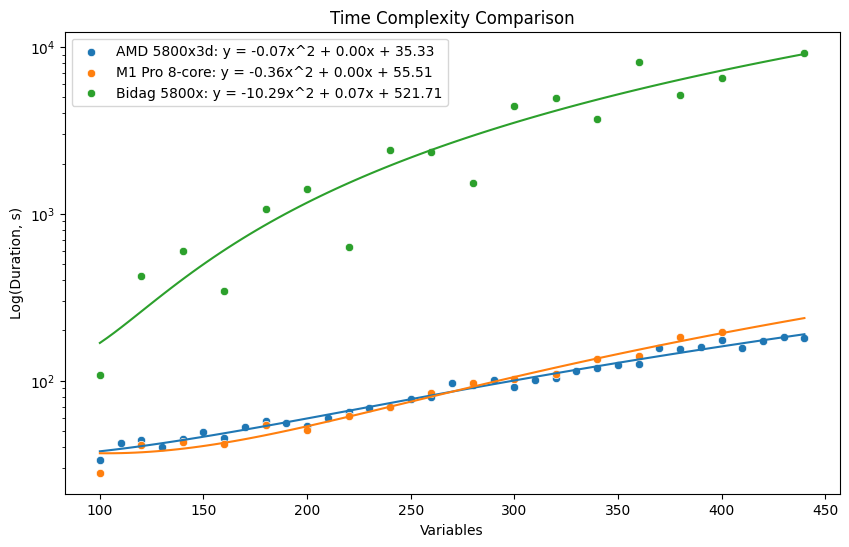

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

results_amd_5800x3d = [{'variables': 100, 'duration': 33.55898880958557},
 {'variables': 110, 'duration': 42.41011571884155},
 {'variables': 120, 'duration': 43.851377725601196},
 {'variables': 130, 'duration': 40.22161738077799},
 {'variables': 140, 'duration': 44.97185786565145},
 {'variables': 150, 'duration': 49.20991023381551},
 {'variables': 160, 'duration': 45.58039410909017},
 {'variables': 170, 'duration': 53.09674938519796},
 {'variables': 180, 'duration': 57.14670546849569},
 {'variables': 190, 'duration': 55.86485083897909},
 {'variables': 200, 'duration': 53.71896576881409},
 {'variables': 210, 'duration': 60.018968184789024},
 {'variables': 220, 'duration': 64.62080947558086},
 {'variables': 230, 'duration': 68.80094695091248},
 {'variables': 240, 'duration': 69.57624276479085},
 {'variables': 250, 'duration': 77.65435568491618},
 {'variables': 260, 'duration': 80.35756214459737},
 {'variables': 270, 'duration': 97.4611929257711},
 {'variables': 280, 'duration': 94.7663984298706},
 {'variables': 290, 'duration': 100.50294987360637},
 {'variables': 300, 'duration': 91.80926219622295},
 {'variables': 310, 'duration': 100.70704078674316},
 {'variables': 320, 'duration': 103.72079277038574},
 {'variables': 330, 'duration': 114.90236934026082},
 {'variables': 340, 'duration': 118.3715029557546},
 {'variables': 350, 'duration': 123.63982383410136},
 {'variables': 360, 'duration': 125.58711091677348},
 {'variables': 370, 'duration': 156.0465773741404},
 {'variables': 380, 'duration': 155.64693927764893},
 {'variables': 390, 'duration': 159.9105533758799},
 {'variables': 400, 'duration': 174.69820721944174},
 {'variables': 410, 'duration': 157.47332048416138},
 {'variables': 420, 'duration': 173.25324829419455},
 {'variables': 430, 'duration': 182.21537001927695},
 {'variables': 440, 'duration': 181.12759121259054}]

results_m1_pro_8core = [{'variables': 100, 'duration': 28.07229733467102},
 {'variables': 120, 'duration': 41.0058696269989},
 {'variables': 140, 'duration': 42.688736279805504},
 {'variables': 160, 'duration': 41.67554839452108},
 {'variables': 180, 'duration': 54.11312389373779},
 {'variables': 200, 'duration': 50.42719705899557},
 {'variables': 220, 'duration': 61.47634975115458},
 {'variables': 240, 'duration': 69.97042298316956},
 {'variables': 260, 'duration': 84.46092391014099},
 {'variables': 280, 'duration': 96.36128862698872},
 {'variables': 300, 'duration': 102.87330500284831},
 {'variables': 320, 'duration': 109.13302596410115},
 {'variables': 340, 'duration': 135.1407539844513},
 {'variables': 360, 'duration': 139.88516624768576},
 {'variables': 380, 'duration': 183.65180929501852},
 {'variables': 400, 'duration': 196.62940200169882}
]

bidag_results_5800x = [{'variables': 100, 'duration': 107.5941},
 {'variables': 120, 'duration': 424.94136},
 {'variables': 140, 'duration': 594.9396},
 {'variables': 160, 'duration': 343.15086},
 {'variables': 180, 'duration': 1069.3152},
 {'variables': 200, 'duration': 1408.1304},
 {'variables': 220, 'duration': 632.2404},
 {'variables': 240, 'duration': 2405.3274},
 {'variables': 260, 'duration': 2354.1102},
 {'variables': 280, 'duration': 1538.4378},
 {'variables': 300, 'duration': 4401.6984},
 {'variables': 320, 'duration': 4924.4436},
 {'variables': 340, 'duration': 3696.9624},
 {'variables': 360, 'duration': 8169.4764},
 {'variables': 380, 'duration': 5181.6456},
 {'variables': 400, 'duration': 6553.476},
 {'variables': 440, 'duration': 9239.5368}
]

df_amd = pd.DataFrame(results_amd_5800x3d)
df_m1 = pd.DataFrame(results_m1_pro_8core)
df_bidag = pd.DataFrame(bidag_results_5800x)

# Fit polynomial regression
degree = 2

# AMD
poly_features = PolynomialFeatures(degree)
X_amd = poly_features.fit_transform(df_amd[['variables']])
y_amd = df_amd['duration']
reg_amd = LinearRegression().fit(X_amd, y_amd)

# M1 Pro
X_m1 = poly_features.fit_transform(df_m1[['variables']])
y_m1 = df_m1['duration']
reg_m1 = LinearRegression().fit(X_m1, y_m1)

# Bidag
X_bidag = poly_features.fit_transform(df_bidag[['variables']])
y_bidag = df_bidag['duration']
reg_bidag = LinearRegression().fit(X_bidag, y_bidag),


# Plot results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_amd, x='variables', y='duration', label='AMD 5800x')
sns.scatterplot(data=df_m1, x='variables', y='duration', label='M1 Pro 8-core')
sns.scatterplot(data=df_bidag, x='variables', y='duration', label='Bidag 5800x')

# Plot polynomial regression lines
X_range = np.linspace(100, 440, 100).reshape(-1, 1)
X_range_poly = poly_features.fit_transform(X_range)

plt.plot(X_range, reg_amd.predict(X_range_poly), label='AMD 5800x Poly Fit')
plt.plot(X_range, reg_m1.predict(X_range_poly), label='M1 Pro 8-core Poly Fit')
plt.plot(X_range, reg_bidag.predict(X_range_poly), label='Bidag 5800x Poly Fit')

# Log scale for y-axis
plt.yscale("log")

# Labels
plt.xlabel('Variables')
plt.ylabel('Log(Duration, s)')
plt.title('Time Complexity Comparison')
# Get coefficients
coeff_amd = reg_amd.coef_[1:], reg_amd.intercept_
coeff_m1 = reg_m1.coef_[1:], reg_m1.intercept_
coeff_bidag = reg_bidag.coef_[1:], reg_bidag.intercept_

# Create strings with the equations
equation_amd = f'AMD 5800x3d: y = {coeff_amd[0][0]:.2f}x^2 + {coeff_amd[0][1]:.2f}x + {coeff_amd[1]:.2f}'
equation_m1 = f'M1 Pro 8-core: y = {coeff_m1[0][0]:.2f}x^2 + {coeff_m1[0][1]:.2f}x + {coeff_m1[1]:.2f}'
equation_bidag = f'Bidag 5800x: y = {coeff_bidag[0][0]:.2f}x^2 + {coeff_bidag[0][1]:.2f}x + {coeff_bidag[1]:.2f}'

# Plot results (same as before)

# Add equations to the legend
plt.legend([equation_amd, equation_m1, equation_bidag])

plt.show()

Estimated time complexity: O(0.0+-8.206755*n^1+0.063929*n^2)


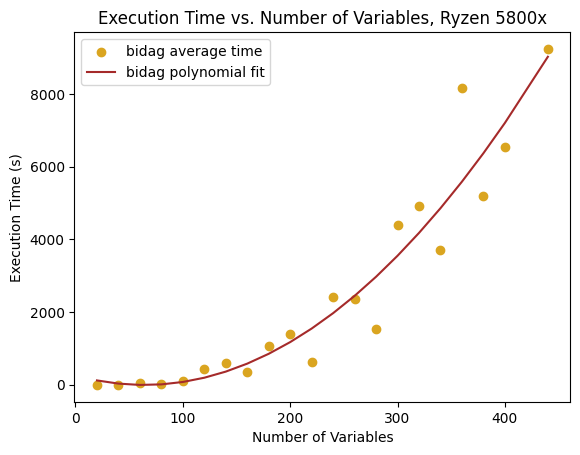

In [24]:
# extract the x and y values from bidag_data
bidag_x_values = bidag_data['number of nodes']
bidag_y_values = bidag_data['exec_time']

# fit a polynomial curve to the data
poly_degree = 2  # degree of the polynomial regression
poly_features = PolynomialFeatures(degree=poly_degree)
x_poly = poly_features.fit_transform(np.array(bidag_x_values).reshape(-1, 1))
poly_model = LinearRegression()
poly_model.fit(x_poly, bidag_y_values)
poly_y_pred = poly_model.predict(x_poly)

# add the bidag_data and polynomial regression to the plot
plt.scatter(bidag_x_values, bidag_y_values, color='goldenrod', label='bidag average time')
plt.plot(bidag_x_values, poly_y_pred, color='brown', label='bidag polynomial fit')
plt.title('Execution Time vs. Number of Variables, Ryzen 5800x')
plt.xlabel('Number of Variables')
plt.ylabel('Execution Time (s)')
plt.legend()

# estimate the time complexity of the algorithm
coef = poly_model.coef_
complexity_str = 'O('
for i in range(len(coef)):
    if i == 0:
        complexity_str += str(round(coef[i], 6))
    else:
        complexity_str += f'+{str(round(coef[i], 6))}*n^{str(i)}'
complexity_str += ')'
print(f"Estimated time complexity: {complexity_str}")

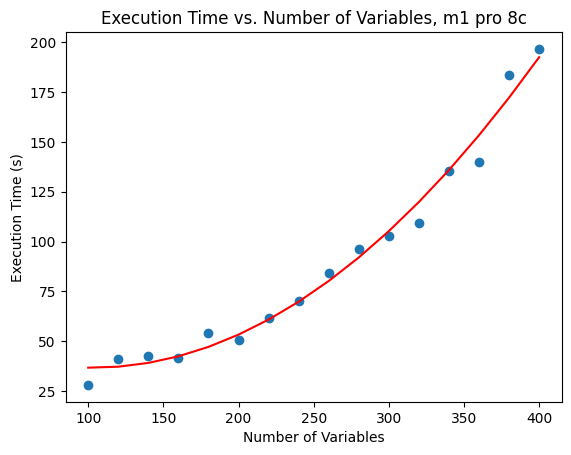

Estimated time complexity: O(0.0+-0.364582*n^1+0.001767*n^2)


In [ ]:
x_values = [result['variables'] for result in results_m1_pro_8core]
y_values = [result['duration'] for result in results_m1_pro_8core]

# fit a polynomial curve to the data
poly_degree = 2  # degree of the polynomial regression
poly_features = PolynomialFeatures(degree=poly_degree)
x_poly = poly_features.fit_transform(np.array(x_values).reshape(-1, 1))
poly_model = LinearRegression()
poly_model.fit(x_poly, y_values)
poly_y_pred = poly_model.predict(x_poly)

# create the plot
plt.scatter(x_values, y_values)
plt.plot(x_values, poly_y_pred, color='red')
plt.title('Execution Time vs. Number of Variables, m1 pro 8c')
plt.xlabel('Number of Variables')
plt.ylabel('Execution Time (s)')
plt.show()

# estimate the time complexity of the algorithm
coef = poly_model.coef_
complexity_str = 'O('
for i in range(len(coef)):
    if i == 0:
        complexity_str += str(round(coef[i], 6))
    else:
        complexity_str += f'+{str(round(coef[i], 6))}*n^{str(i)}'
complexity_str += ')'
print(f"Estimated time complexity: {complexity_str}")

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


data = {'dataset': ['ecoli70', 'hailfinder', 'hepar2', 'magic_irri', 'magic_niab', 'pigs', 'win95pts', 'andes', 'diabetes'],
        'data_type': ['continuous', 'discrete', 'discrete', 'continuous', 'continuous', 'discrete', 'discrete', 'discrete', 'discrete'],
        'shd_lsevo': [39.66, 63.33, 85.0, 77.333333, 54.666667, 490.0, 74.0, 297.33, 594.0],
        'f1_lsevo': [0.572215, 0.479836, 0.505263, 0.328704, 0.282016, 0.510259, 0.589862, 0.382214, 0.287690],
        'time_lsevo': [20.330601, 26.115666, 22.376997, 23.918053, 19.641882, 134.663579, 25.024325, 89.976317, 150.839022],
        'f1_undir_lsevo': [0.7732, 0.563233, 0.600000, 0.576600, 0.718400, 0.615500, 0.718900, 0.542433, 0.570167],
        'shd_bidag': [9, 46, 66, 19, 6, 35, 60, 117, 453],
        'f1_bidag': [0.914286, 0.567164, 0.590476, 0.862559, 0.909091, 0.958298, 0.675439, 0.720737, 0.444240],
        'time_bidag':[0.94, 1328.2272, 1905.402, 1.25, 0.898, 8630.3592, 993.6678, 171.48, 931.2],
        'f1_undir_bidag': [0.9571, 0.7463, 0.7810, 0.9573, 1.0000, 0.9821, 0.7982, 0.884903, 0.720737],
        'shd_sparsebn': [55, 61, 147, 66, 29, 483, 139, 253, 842],
        'f1_sparsebn': [0.510949, 0.477612, 0.316981, 0.468900, 0.602941, 0.351227, 0.263636, 0.5433, 0.2205],
        'f1_undir_sparsebn': [0.6861, 0.6119, 0.5736, 0.8995, 0.9706, 0.9080, 0.4727, 0.725434, 0.498859],
        'time_sparsebn': [5.547351, 350.45382, 16.58553, 21.68742, 6.791835, 11000, 13.75046, 2148, 74520]}


#       dataset   data_type         shd        f1  f1_undir        time
# 7       andes    discrete  297.333333  0.382214  0.542433   89.976317
# 8    diabetes    discrete  594.000000  0.287690  0.570167  150.839022



df = pd.DataFrame(data)

#       dataset shd_bidag  f1_bidag  f1_undir_bidag shd_sparsebn  f1_sparsebn  \
# 0        pigs        35  0.958298        0.982128          483     0.351227   
# 1    win95pts        60  0.675439        0.798246          139     0.263636   
# 2  hailfinder        46  0.567164        0.746269           61     0.477612   
# 3      hepar2        66  0.590476        0.780952          147     0.316981   
# 4     ecoli70         9  0.914286        0.957143           55     0.510949   
# 5  magic_irri        19  0.862559        0.957346           66     0.468900   
# 6  magic_niab         6  0.909091        1.000000           29     0.602941   
# 7    diabetes       453  0.444240        0.720737          842     0.220532   
# 8       andes       117  0.765321        0.884903          253     0.543353   

#    f1_undir_sparsebn  
# 0           0.907975  
# 1           0.472727  
# 2           0.611940  
# 3           0.573585  
# 4           0.686131  
# 5           0.899522  
# 6           0.970588  
# 7           0.498859  
# 8           0.725434  

#       dataset shd_random  f1_random  f1_undir_random
# 0     ecoli70        134   0.028571           0.0571
# 1  magic_irri        200   0.009804           0.0294
# 2  magic_niab        125   0.015152           0.0909
# 3        pigs       1179   0.003378           0.0051
# 4    win95pts        211   0.035714           0.0804
# 5  hailfinder        129   0.015152           0.0303
# 6      hepar2        238   0.032520           0.0325
# 7       andes        669   0.005917           0.0148
# 8    diabetes       1200   0.001661           0.0050


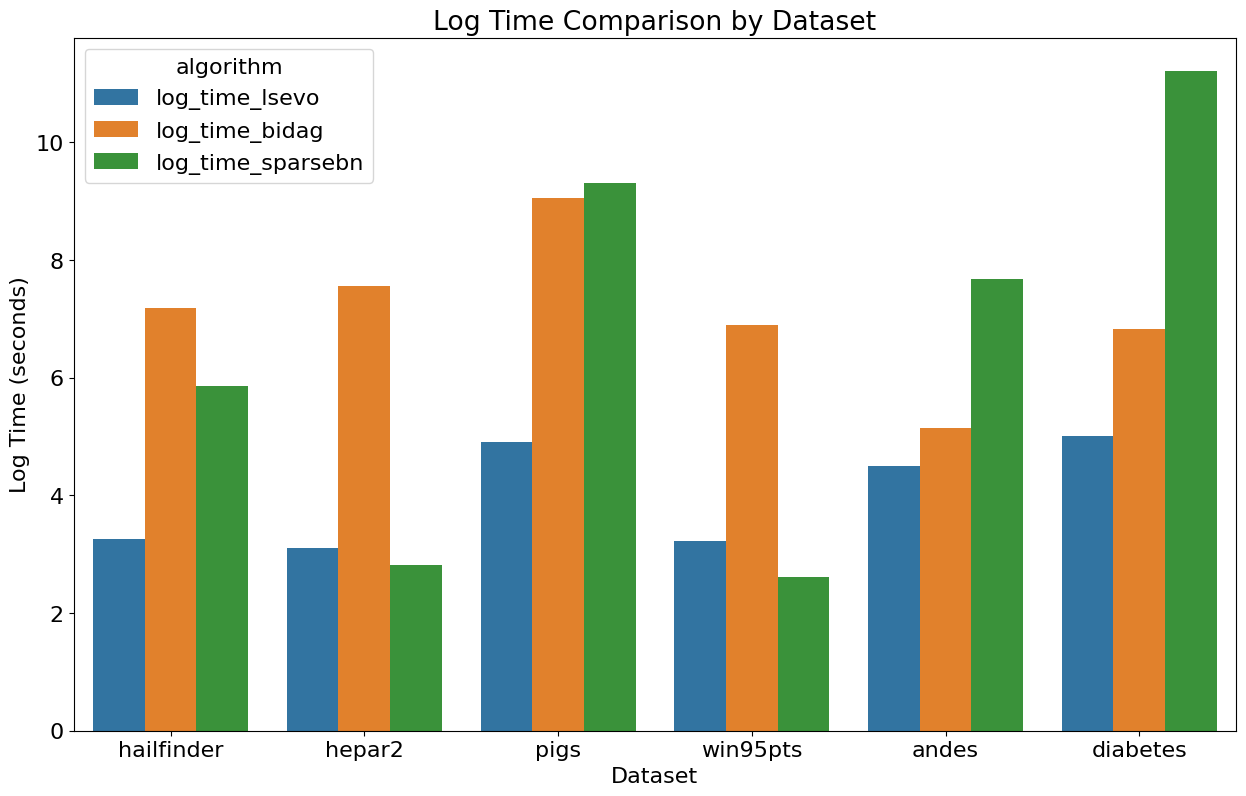

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame
df = pd.DataFrame(data)

df = df[~df['dataset'].isin(['ecoli70', 'magic_niab', 'magic_irri'])]

# Grouped barplot of Log Time by Dataset
plt.figure(figsize=(15, 9))

# Calculate the logarithm of time for each algorithm
df['log_time_lsevo'] = np.log(df['time_lsevo'])
df['log_time_bidag'] = np.log(df['time_bidag'])
df['log_time_sparsebn'] = np.log(df['time_sparsebn'])

# Create the barplot
sns.barplot(
    x='dataset',
    y='value',
    hue='algorithm',
    data=df.melt(
        id_vars=['dataset', 'data_type'],
        value_vars=['log_time_lsevo', 'log_time_bidag', 'log_time_sparsebn'],
        var_name='algorithm',
        value_name='value'
    )
)

# Set labels and title
plt.title('Log Time Comparison by Dataset')
plt.xlabel('Dataset')
plt.ylabel('Log Time (seconds)')
plt.show()


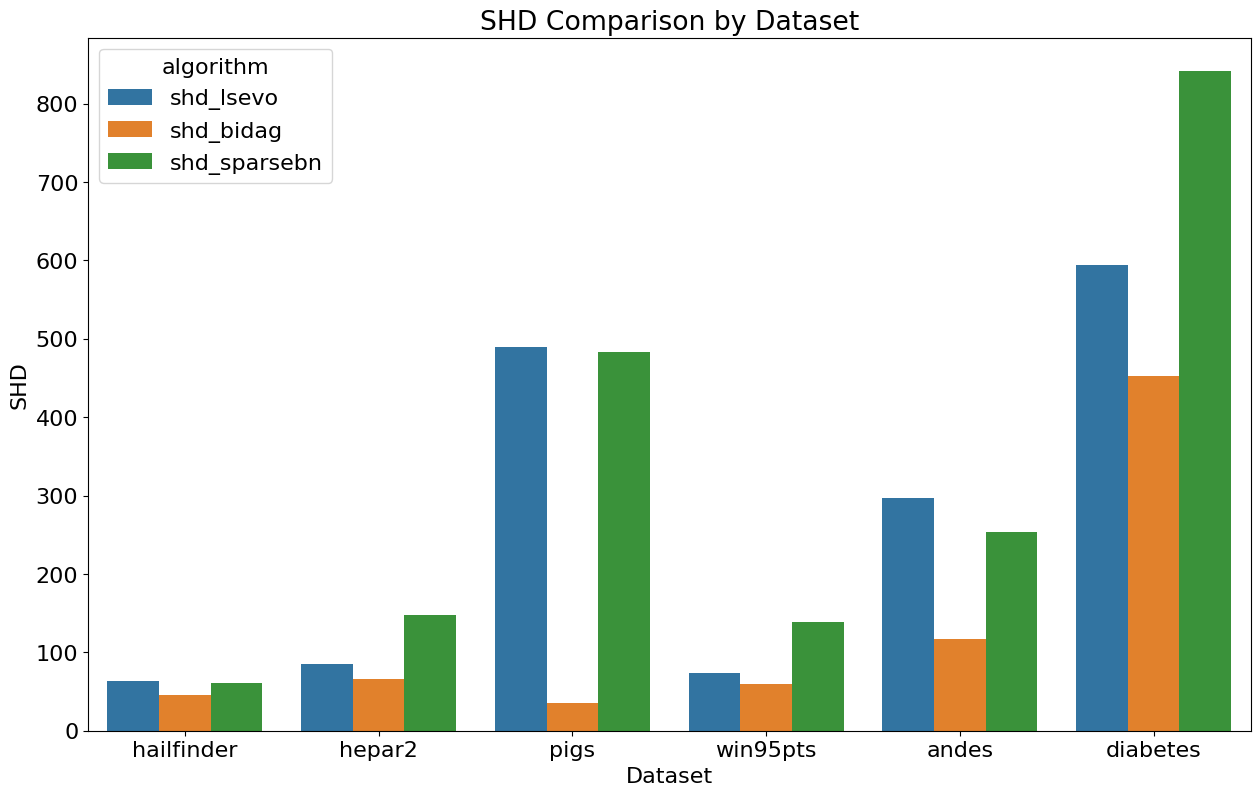

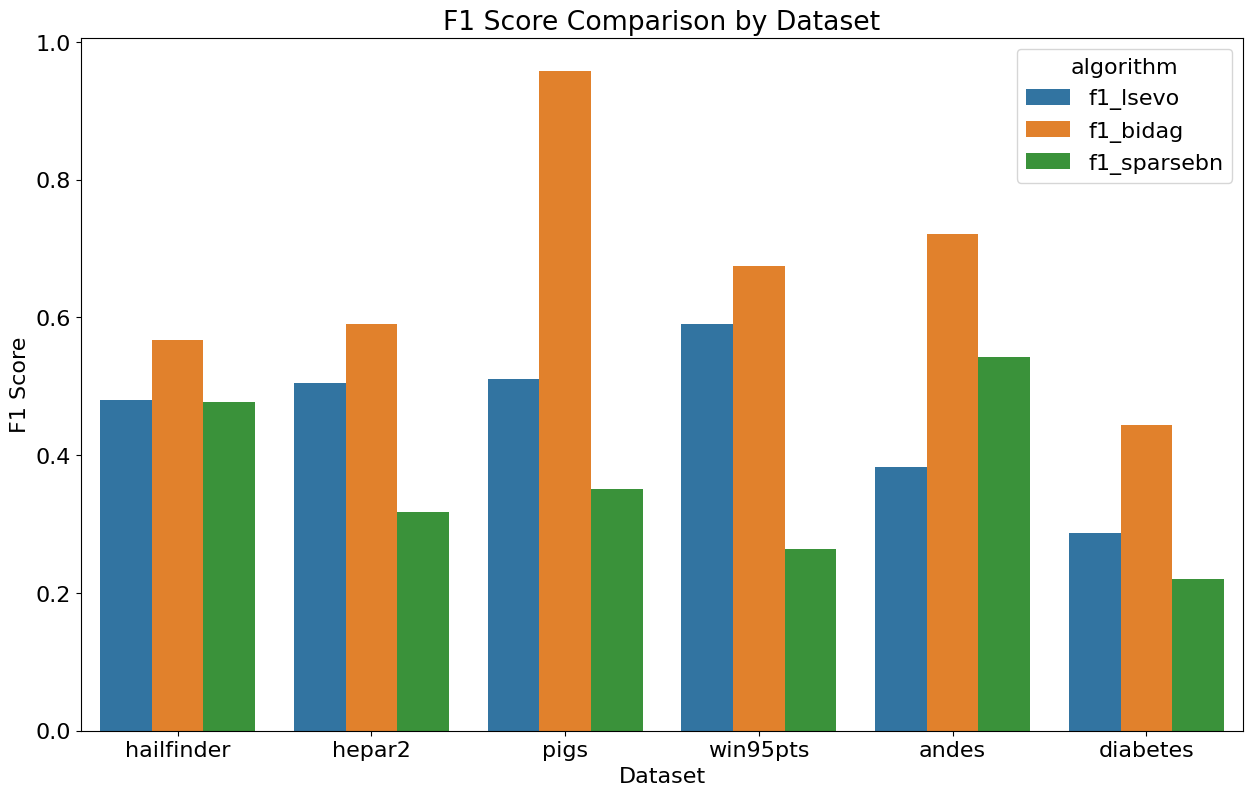

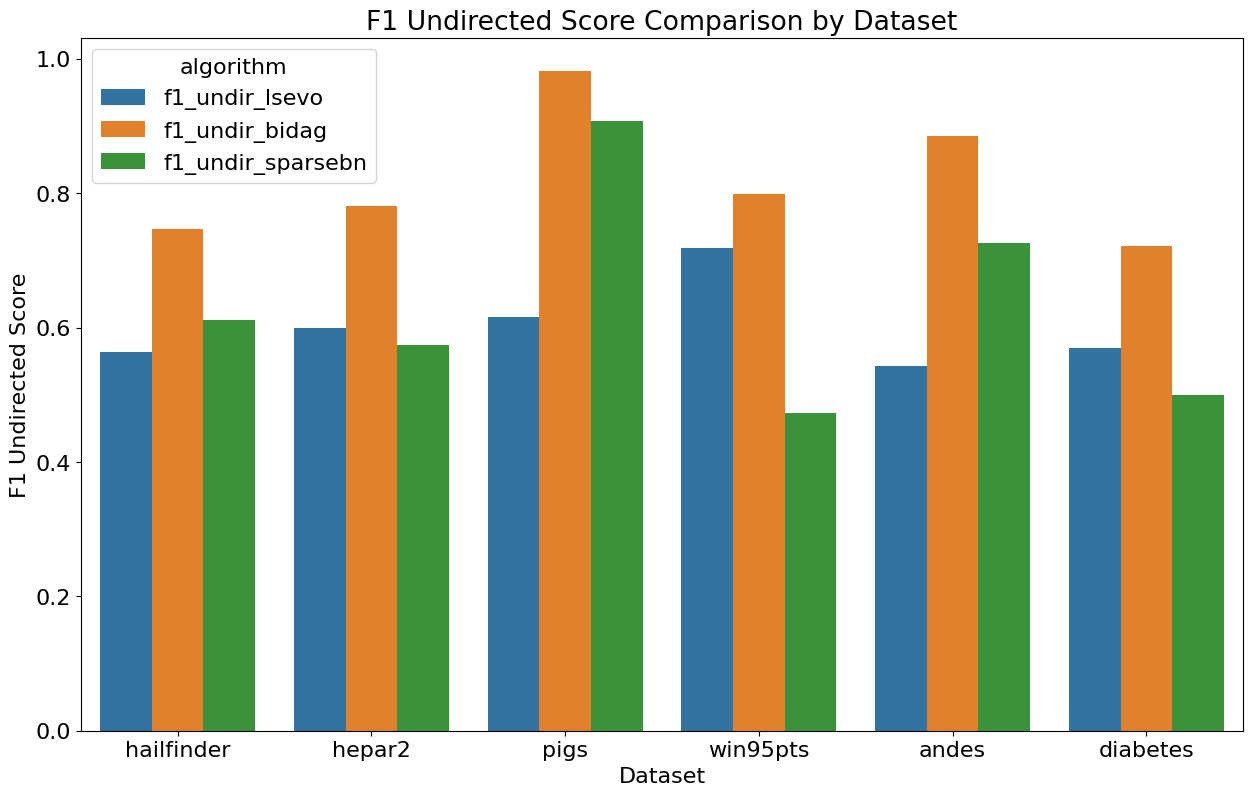

In [10]:
# Grouped barplot of SHD by Dataset
plt.figure(figsize=(15, 9))
sns.barplot(x='dataset', y='shd', hue='algorithm', data=df.melt(id_vars=['dataset', 'data_type'], value_vars=['shd_lsevo', 'shd_bidag', 'shd_sparsebn'], var_name='algorithm', value_name='shd'))
plt.title('SHD Comparison by Dataset')
plt.xlabel('Dataset')
plt.ylabel('SHD')
plt.show()

# Grouped barplot of F1 Score by Dataset
plt.figure(figsize=(15, 9))
sns.barplot(x='dataset', y='f1', hue='algorithm', data=df.melt(id_vars=['dataset', 'data_type'], value_vars=['f1_lsevo', 'f1_bidag', 'f1_sparsebn'], var_name='algorithm', value_name='f1'))
plt.title('F1 Score Comparison by Dataset')
plt.xlabel('Dataset')
plt.ylabel('F1 Score')
plt.show()

plt.figure(figsize=(15, 9))
sns.barplot(x='dataset', y='f1_undirected', hue='algorithm', data=df.melt(id_vars=['dataset', 'data_type'], value_vars=['f1_undir_lsevo', 'f1_undir_bidag', 'f1_undir_sparsebn'], var_name='algorithm', value_name='f1_undirected'))
plt.title('F1 Undirected Score Comparison by Dataset')
plt.xlabel('Dataset')
plt.ylabel('F1 Undirected Score')
plt.show()

## Score-function convergence

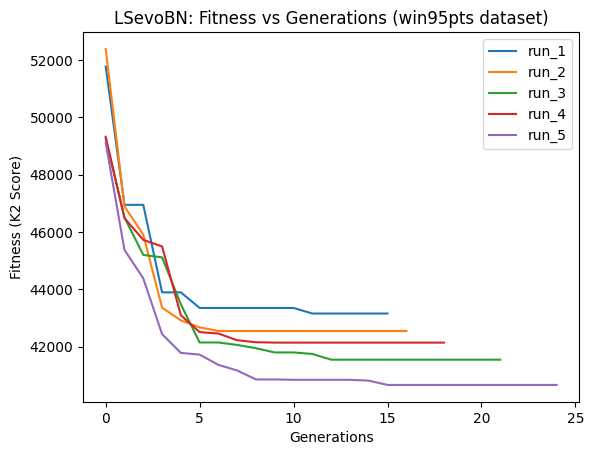

In [9]:
import matplotlib.pyplot as plt

# Fitness data
fitness = {'run_1': [51775.062, 46950.692, 46950.692, 43898.075, 43898.075, 43353.780, 43353.780, 43353.780, 43353.780, 43353.780, 43353.780, 43160.255, 43160.255, 43160.255, 43160.255, 43160.255],
'run_2': [52388.294, 46896.789, 45909.773, 43365.164, 42920.946, 42677.318, 42552.277, 42551.150, 42551.150, 42551.150, 42551.150, 42551.150, 42551.150, 42551.150, 42551.150, 42551.150, 42551.150],
'run_3': [49253.299, 46508.138, 45203.675, 45119.051, 43483.064, 42150.214, 42150.214, 42064.240, 41949.812, 41802.151, 41802.151, 41750.152, 41550.527, 41550.527, 41550.527, 41550.527, 41550.527, 41550.527, 41550.527, 41550.527, 41550.527, 41550.527],
'run_4': [49325.263, 46488.362, 45729.883, 45500.434, 43101.351, 42511.529, 42462.224, 42227.904, 42159.111, 42145.738, 42145.738, 42145.738, 42145.738, 42145.738, 42145.738, 42145.738, 42145.738, 42145.738, 42145.738], 
'run_5': [49115.110, 45379.152, 44387.612, 42441.959, 41787.585, 41726.348, 41369.006, 41172.714, 40860.771, 40860.771, 40848.762, 40848.762, 40848.762, 40848.762, 40818.368, 40669.969, 40669.969, 40669.969, 40669.969, 40669.969, 40669.969, 40669.969, 40669.969, 40669.969, 40669.969]}

# Plotting the graph
for key in fitness.keys():
    plt.plot(fitness[key], label=key)
plt.title('LSevoBN: Fitness vs Generations (win95pts dataset)')
plt.xlabel('Generations')
plt.ylabel('Fitness (K2 Score)')
plt.legend()
plt.show()

## Different number of clusters in K-means

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def different_kmeans_test(datasets, num_runs=5):
    results_df = pd.DataFrame(columns=['dataset', 'data_type', 'hidden_nodes_clusters', 'shd', 'f1', 'time'])

    for dataset_name, (data, reference_dag_edges, datatype, max_local_structures) in datasets.items():
        for hidden_nodes_clusters in range(4, 17):
            for i in range(num_runs):
                start_time = time.time()

                custom_dag_edges = get_edges_by_localstructures(data,
                                                                datatype,
                                                                max_local_structures,
                                                                hidden_nodes_clusters,
                                                                time_m=5)

                end_time = time.time()

                structure_learning_time = end_time - start_time

                f1 = f1_score(custom_dag_edges, reference_dag_edges.values.tolist())

                results_df = results_df.append({
                    'dataset': dataset_name,
                    'data_type': datatype,
                    'hidden_nodes_clusters': hidden_nodes_clusters,
                    'shd': float(precision_recall(custom_dag_edges, reference_dag_edges.values.tolist())['SHD']),
                    'f1': f1,
                    'time': structure_learning_time
                }, ignore_index=True)

                print(results_df)

    return results_df


In [ ]:
datasets = {
    "ecoli70": (ecoli70, ecoli70_true, "continuous", 4),
    "magic_irri": (magic_irri, magic_irri_true, "continuous", 4),
    "magic_niab": (magic_niab, magic_niab_true, "continuous", 4),
#    "pigs": (pigs, pigs_true, "discrete", 16),
    "win95pts": (win95pts, win95pts_true, "discrete", 4),
    "hailfinder": (hailfinder, hailfinder_true, "discrete", 8),
    "hepar2": (hepar2, hepar2_true, "discrete", 4)
#    "arth150": (arth150, arth150_true, "continuous", 8),
}

results_df_kmeans_lsevo = different_kmeans_test(datasets)

# results_df_kmeans_lsevo.to_csv('results_df_kmeans_lsevo.csv', index=False)



In [ ]:
# results_df_kmeans_lsevo = pd.read_csv('results_df_kmeans_lsevo.csv')

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(results_df_kmeans_lsevo)

sns.set(style='whitegrid')
g = sns.FacetGrid(df, col='dataset', height=6, aspect=1)
g.map(sns.boxplot, 'hidden_nodes_clusters', 'f1', order=None)
g.set_axis_labels('Number of Clusters', 'F1 Score')
g.set_titles('{col_name}')

plt.show()

In [ ]:
# Group by dataset, data_type, and hidden_nodes_clusters
grouped_results_df = results_df_kmeans_lsevo[results_df_kmeans_lsevo['dataset']=='win95pts'].groupby(['dataset', 'data_type', 'hidden_nodes_clusters'], as_index=False)

# Extract the necessary data
time_data = [group['time'].values for name, group in grouped_results_df]
f1_data = [group['f1'].values for name, group in grouped_results_df]

# Create the boxplots
fig, ax = plt.subplots()
ax.boxplot(time_data, positions=grouped_results_df['hidden_nodes_clusters'].unique(), widths=0.6)
ax.boxplot(f1_data, positions=grouped_results_df['hidden_nodes_clusters'].unique() + 0.4, widths=0.6)

# Add labels and legends
ax.set_xlabel('Number of Hidden Nodes Clusters')
ax.set_ylabel('Time (s) and F1')
ax.legend(['Time', 'F1'])

plt.show()


In [ ]:
results_df_kmeans_lsevo.groupby(['dataset', 'data_type', 'hidden_nodes_clusters']).mean()


shd        f1        time
dataset  data_type  hidden_nodes_clusters                              
ecoli70  continuous 4                        99.6  0.401224   29.919485
                    5                       101.4  0.392343   30.851056
                    6                       100.6  0.393328   30.077484
                    7                        99.6  0.387079   29.220439
                    8                        78.0  0.473865   28.063883
...                                           ...       ...         ...
win95pts discrete   12                     1185.8  0.107447  194.424560
                    13                     1069.2  0.108879  204.038744
                    14                     1079.8  0.108742  217.506576
                    15                     1074.6  0.108884  233.604560
                    16                     1086.0  0.107799  245.364551

[78 rows x 3 columns]

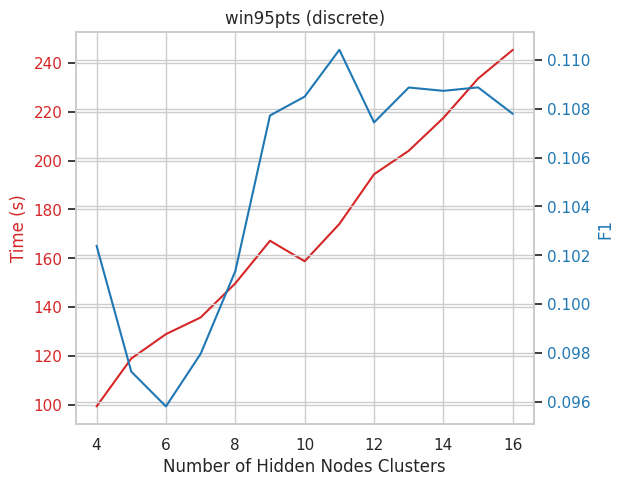

In [ ]:
    # Group by dataset, data_type, and hidden_nodes_clusters and calculate the mean of each group
    grouped_results_df = results_df_kmeans_lsevo[results_df_kmeans_lsevo['dataset']=='win95pts'].groupby(['dataset', 'data_type', 'hidden_nodes_clusters'], as_index=False).mean()

    # Plot the results
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Number of Hidden Nodes Clusters')
    ax1.set_ylabel('Time (s)', color='tab:red')
    ax1.plot(grouped_results_df['hidden_nodes_clusters'], grouped_results_df['time'], color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel('F1', color='tab:blue')  # we already handled the x-label with ax1
    ax2.plot(grouped_results_df['hidden_nodes_clusters'], grouped_results_df['f1'], color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('win95pts (discrete)')
    plt.show()

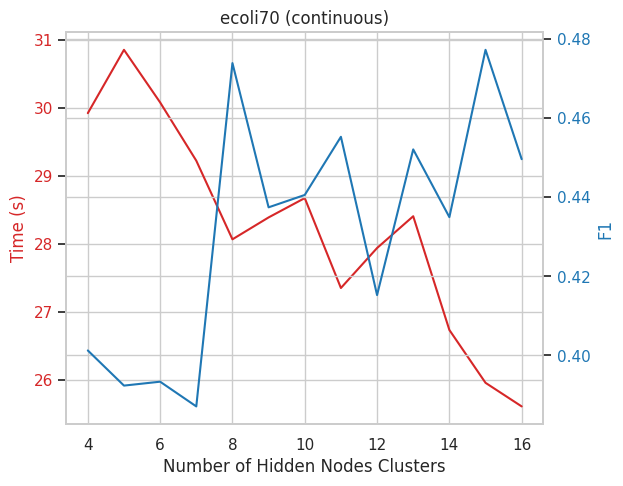

In [ ]:
    # Group by dataset, data_type, and hidden_nodes_clusters and calculate the mean of each group
    grouped_results_df = results_df_kmeans_lsevo[results_df_kmeans_lsevo['dataset']=='ecoli70'].groupby(['dataset', 'data_type', 'hidden_nodes_clusters'], as_index=False).mean()

    # Plot the results
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Number of Hidden Nodes Clusters')
    ax1.set_ylabel('Time (s)', color='tab:red')
    ax1.plot(grouped_results_df['hidden_nodes_clusters'], grouped_results_df['time'], color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel('F1', color='tab:blue')  # we already handled the x-label with ax1
    ax2.plot(grouped_results_df['hidden_nodes_clusters'], grouped_results_df['f1'], color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('ecoli70 (continuous)')
    plt.show()

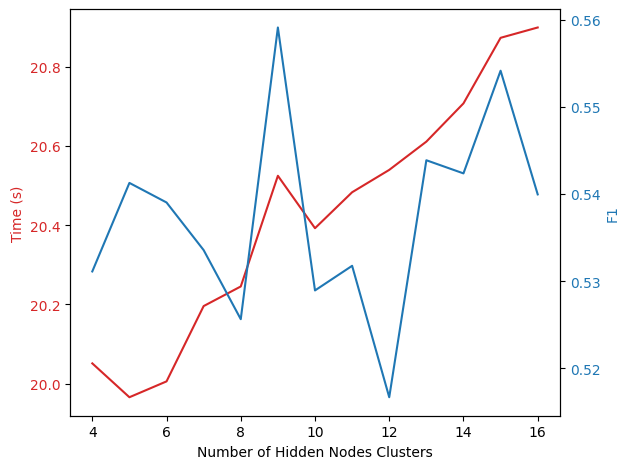

In [ ]:
    # Group by dataset, data_type, and hidden_nodes_clusters and calculate the mean of each group
    grouped_results_df = results_df_kmeans_lsevo[results_df_kmeans_lsevo['dataset']=='ecoli70'].groupby(['dataset', 'data_type', 'hidden_nodes_clusters'], as_index=False).mean()

    # Plot the results
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Number of Hidden Nodes Clusters')
    ax1.set_ylabel('Time (s)', color='tab:red')
    ax1.plot(grouped_results_df['hidden_nodes_clusters'], grouped_results_df['time'], color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel('F1', color='tab:blue')  # we already handled the x-label with ax1
    ax2.plot(grouped_results_df['hidden_nodes_clusters'], grouped_results_df['f1'], color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

In [15]:
import itertools

def generate_random_dag(nodes, num_edges):
    all_edges = list(itertools.permutations(nodes, 2))
    random_edges = np.random.choice(len(all_edges), num_edges, replace=False)
    random_dag_edges = [all_edges[i] for i in random_edges]
    return pd.DataFrame(random_dag_edges, columns=["source", "target"])

def calculate_f1_shd_random(networks):
    
    results_df = pd.DataFrame(columns=['dataset',
                                       'shd_random',
                                       'f1_random',
                                       'f1_undir_random'])
    
    for dataset_name, (reference_dag_edges) in networks.items():
        
        nodes = np.unique(reference_dag_edges).tolist()  # Updated to convert to a list
        num_edges = len(reference_dag_edges)
        
        random_dag = generate_random_dag(nodes, num_edges)  # Updated to pass a list of nodes
        
        f1_random = f1_score(random_dag.values.tolist(), reference_dag_edges.values.tolist())   
        f1_undir_random = precision_recall(random_dag.values.tolist(), reference_dag_edges.values.tolist())['F1_undir']      
        shd_random = precision_recall(random_dag.values.tolist(), reference_dag_edges.values.tolist())['SHD']
        
        results_df = results_df.append({
            'dataset': f"{dataset_name}",
            'shd_random': shd_random,
            'f1_random': f1_random,
            'f1_undir_random': f1_undir_random
        }, ignore_index=True)
    
    return results_df


In [17]:
datasets = {
    "ecoli70": (ecoli70_true),
    "magic_irri": (magic_irri_true),
    "magic_niab": (magic_niab_true),
    "pigs": (pigs_true),
    "win95pts": (win95pts_true),
    "hailfinder": (hailfinder_true),
    "hepar2": (hepar2_true),
    "andes": (andes_true),
    "diabetes": (diabetes_true)
#    "arth150": (arth150, arth150_true, "continuous", 8),
}

random_generated_res = calculate_f1_shd_random(datasets)

print(random_generated_res)

      dataset shd_random  f1_random  f1_undir_random
0     ecoli70        134   0.028571           0.0571
1  magic_irri        200   0.009804           0.0294
2  magic_niab        125   0.015152           0.0909
3        pigs       1179   0.003378           0.0051
4    win95pts        211   0.035714           0.0804
5  hailfinder        129   0.015152           0.0303
6      hepar2        238   0.032520           0.0325
7       andes        669   0.005917           0.0148
8    diabetes       1200   0.001661           0.0050


In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

data_lsevo = {'dataset': ['ecoli70', 'hailfinder', 'hepar2', 'magic_irri', 'magic_niab', 'pigs', 'win95pts', 'andes', 'diabetes'],
              'shd_lsevo': [39.66, 63.33, 85.0, 77.333333, 54.666667, 490.0, 74.0, 297.33, 594.0],
              'f1_lsevo': [0.572215, 0.479836, 0.505263, 0.328704, 0.282016, 0.510259, 0.589862, 0.382214, 0.287690],
              'f1_undir_lsevo': [0.7732, 0.563233, 0.600000, 0.576600, 0.718400, 0.615500, 0.718900, 0.542433, 0.570167]}

# Random DAGs data
data_random = {'dataset': ['ecoli70', 'magic_irri', 'magic_niab', 'pigs', 'win95pts', 'hailfinder', 'hepar2', 'andes', 'diabetes'],
               'shd_random': [134, 200, 125, 1179, 211, 129, 238, 669, 1200],
               'f1_random': [0.028571, 0.009804, 0.015152, 0.003378, 0.035714, 0.015152, 0.032520, 0.005917, 0.001661],
               'f1_undir_random': [0.0571, 0.0294, 0.0909, 0.0051, 0.0804, 0.0303, 0.0325, 0.0148, 0.0050]}

# Combine the data into a single DataFrame
df_lsevo = pd.DataFrame(data_lsevo)
df_random = pd.DataFrame(data_random)
df_combined = pd.merge(df_lsevo, df_random, on='dataset')

df_combined = df_combined[~df_combined['dataset'].isin(['ecoli70', 'magic_niab', 'magic_irri'])]

# Plot the comparison
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

fig.suptitle('Comparison of SHD and F1 scores between LSevoBN and Random DAGs')

# SHD comparison
sns.barplot(x='dataset', y='value', hue='type', data=df_combined.melt(id_vars='dataset', value_vars=['shd_lsevo', 'shd_random'], var_name='type', value_name='value'), ax=axs[0])
axs[0].set_title('SHD Comparison')
axs[0].set_xlabel('Dataset')
axs[0].set_ylabel('SHD')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)

sns.barplot(x='dataset', y='value', hue='type', data=df_combined.melt(id_vars='dataset', value_vars=['f1_lsevo', 'f1_random'], var_name='type', value_name='value'), ax=axs[1])
axs[1].set_title('F1 Comparison')
axs[1].set_xlabel('Dataset')
axs[1].set_ylabel('F1')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)

sns.barplot(x='dataset', y='value', hue='type', data=df_combined.melt(id_vars='dataset', value_vars=['f1_undir_lsevo', 'f1_undir_random'], var_name='type', value_name='value'), ax=axs[2])
axs[2].set_title('F1 Undirected Comparison')
axs[2].set_xlabel('Dataset')
axs[2].set_ylabel('F1 Undirected')
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45)